<a href="https://colab.research.google.com/github/Namratha0506/NLPLLM_AssgnCode/blob/main/CodeForAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install transformers -q
!pip install -U scikit-learn -q
!pip install wordcloud -q

# Import core libraries for data handling and regular expressions
import pandas as pd
import numpy as np
import re

# Import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import NLP tools for text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import sklearn modules for data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Import Hugging Face transformer classes for BERT
from transformers import BertTokenizer, BertForSequenceClassification

# Import PyTorch utilities for model building and training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm

# Set computation device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device set to: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 82.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
Computation device set to: cuda


In [2]:
# Load the combined financial sentiment dataset (FiQA + Financial PhraseBank) from GitHub
Findata = 'https://raw.githubusercontent.com/Namratha0506/NLPLLM_AssgnCode/refs/heads/main/data.csv'
# Read the CSV file into a pandas DataFrame
Findata_Data = pd.read_csv(Findata)
# Display the first few rows of the financial dataset
print(Findata_Data.head())

                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral


In [3]:
# Standardize all column names to lowercase
Findata_Data.columns = [col.lower() for col in Findata_Data.columns]

In [4]:
# Show structure and types of the columns in the financial sentiment dataset
print('\n📊 Dataset Overview:\n')
print(Findata_Data.info())


📊 Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   5842 non-null   object
 1   sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None


In [5]:
# Display summary statistics for any numeric columns
print('\n📈 Summary Statistics:\n')
print(Findata_Data.describe())


📈 Summary Statistics:

                                                 sentence sentiment
count                                                5842      5842
unique                                               5322         3
top     Operating loss totalled EUR 0.9 mn , down from...   neutral
freq                                                    2      3130


In [6]:
# Count and display the number of duplicate entries in the dataset
print('\n🔁 Number of Duplicate Records:', Findata_Data.duplicated().sum())


🔁 Number of Duplicate Records: 6


In [9]:
# Remove duplicate rows from the dataset
Findata_Data = Findata_Data.drop_duplicates()
# Confirm that all duplicate entries have been removed
print('\n Number of Duplicate Records After Removal:', Findata_Data.duplicated().sum())


 Number of Duplicate Records After Removal: 0


In [10]:
# Check for missing values in each column of the dataset
print('\n Missing Values by Column:\n')
print(Findata_Data.isnull().sum())


 Missing Values by Column:

sentence     0
sentiment    0
dtype: int64


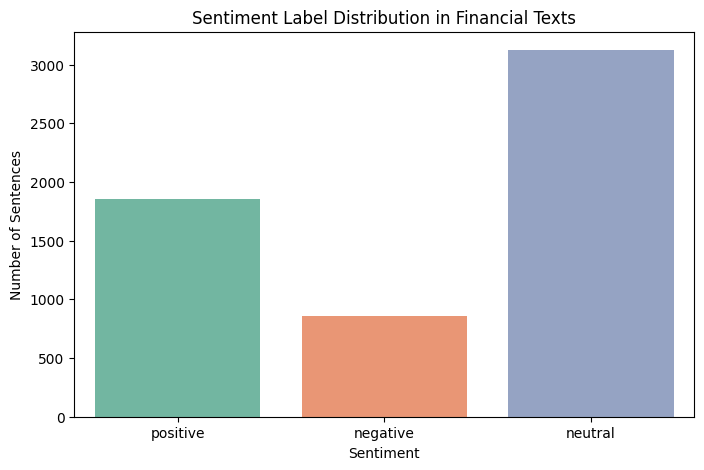

In [11]:
# Create a new figure with defined size for better visibility
plt.figure(figsize=(8, 5))
# Plot the count of each sentiment label using seaborn
sns.countplot(data=Findata_Data, x='sentiment', hue='sentiment', palette='Set2', legend=False)
# Set the title of the plot
plt.title('Sentiment Label Distribution in Financial Texts')
# Label the x-axis and y-axis
plt.xlabel('Sentiment')
plt.ylabel('Number of Sentences')
# Display the plot
plt.show()

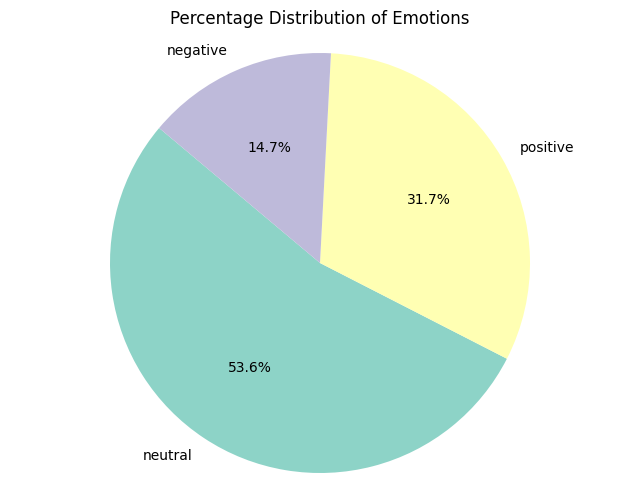

In [7]:
# Calculate the frequency of each sentiment category in the dataset
Sentiment_counts = Findata_Data['sentiment'].value_counts()
# Extract sentiment category names
Sentiment_labels = Sentiment_counts.index
# Extract the corresponding counts for each sentiment
Sentiment_sizes = Sentiment_counts.values
# Create a pie chart to visualize sentiment distribution percentages
plt.figure(figsize=(8, 6))
plt.pie(Sentiment_sizes,labels=Sentiment_labels,autopct='%1.1f%%',
        startangle=140,colors=plt.cm.Set3.colors)
# Set the title of the chart
plt.title('Percentage Distribution of Sentiments')
# Ensure the pie chart is a perfect circle
plt.axis('equal')
# Display the chart
plt.show()

In [12]:
# Convert the 'sentiment' column to categorical data type
Findata_Data['sentiment'] = Findata_Data['sentiment'].astype('category')
# Create a new column with encoded numeric values for each sentiment class
Findata_Data['sentiment_encoded'] = Findata_Data['sentiment'].cat.codes
# Retrieve the original sentiment category names in order of their assigned numeric codes
Sentiment_label_names = Findata_Data['sentiment'].cat.categories.tolist()
# Print the numeric-to-text sentiment label mapping
print("Sentiment label encoding:\n", dict(enumerate(Sentiment_label_names)))

Sentiment label encoding:
 {0: 'negative', 1: 'neutral', 2: 'positive'}


In [13]:
# Check the original distribution of sentiment categories in the financial dataset
fin_sentiment_counts = Findata_Data['sentiment_encoded'].value_counts()
print("Original sentiment distribution in financial text:\n", fin_sentiment_counts)

# Find the maximum class count for oversampling
fin_max_count = fin_sentiment_counts.max()

# List to collect oversampled subsets for each sentiment
fin_oversampled_data = []

# Loop through each sentiment code and balance its count by oversampling
for sentiment_code in fin_sentiment_counts.index:
    sentiment_rows = Findata_Data[Findata_Data['sentiment_encoded'] == sentiment_code]
    rows_to_add = fin_max_count - len(sentiment_rows)

    if rows_to_add > 0:
        extra_rows = sentiment_rows.sample(rows_to_add, replace=True, random_state=123456)
        sentiment_rows = pd.concat([sentiment_rows, extra_rows])

    fin_oversampled_data.append(sentiment_rows)

# Concatenate and shuffle the balanced sentiment dataset
Balanced_FinSent_Data = pd.concat(fin_oversampled_data).sample(frac=1, random_state=123456).reset_index(drop=True)

# Display the class distribution after balancing
print("\n Balanced sentiment distribution:\n", Balanced_FinSent_Data['sentiment_encoded'].value_counts())


Original sentiment distribution in financial text:
 sentiment_encoded
1    3124
2    1852
0     860
Name: count, dtype: int64

 Balanced sentiment distribution:
 sentiment_encoded
0    3124
2    3124
1    3124
Name: count, dtype: int64


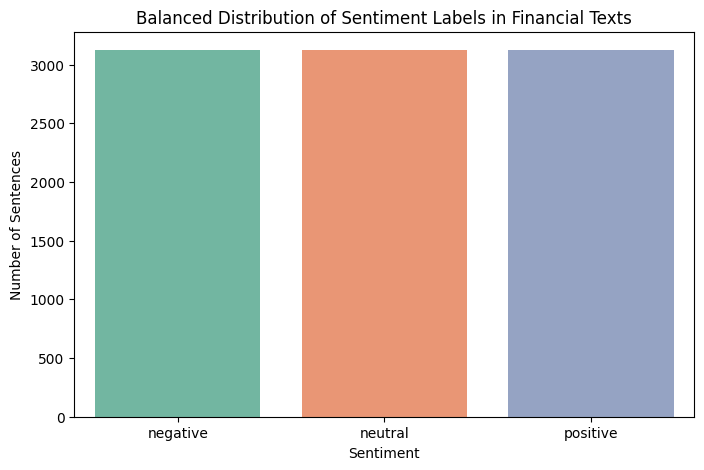

In [14]:
# Create a bar plot to show the distribution of sentiment labels after oversampling
plt.figure(figsize=(8, 5))
# Count the number of samples in each sentiment category
sns.countplot(data=Balanced_FinSent_Data, x='sentiment', hue='sentiment', palette='Set2', legend=False)
# Set the plot title
plt.title('Balanced Distribution of Sentiment Labels in Financial Texts')
# Label the x-axis and y-axis
plt.xlabel('Sentiment')
plt.ylabel('Number of Sentences')
# Show the plot
plt.show()


 Sentence Length Statistics:
 count    5836.000000
mean      116.964702
std        56.318951
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: fin_sentence_length, dtype: float64


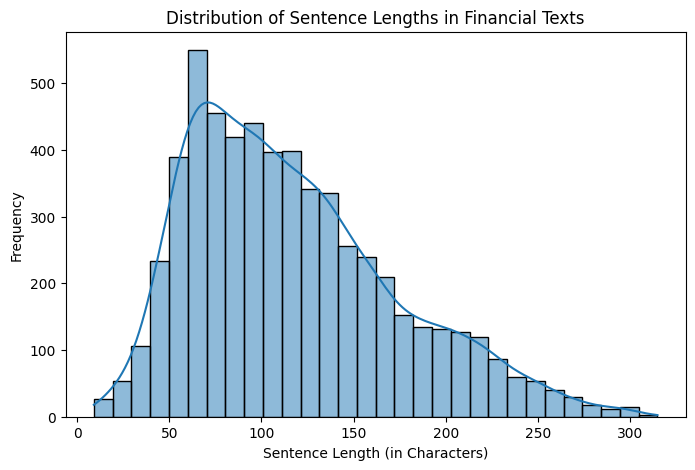

In [15]:
# Add a new column that stores the character length of each sentence
Findata_Data['fin_sentence_length'] = Findata_Data['sentence'].apply(len)
# Print descriptive statistics (mean, min, max, etc.) for sentence lengths
print("\n Sentence Length Statistics:\n", Findata_Data['fin_sentence_length'].describe())
# Create a new figure for the sentence length distribution plot
plt.figure(figsize=(8, 5))
# Plot a histogram with a density curve to show sentence length distribution
sns.histplot(Findata_Data['fin_sentence_length'], bins=30, kde=True)
# Set the title of the plot
plt.title("Distribution of Sentence Lengths in Financial Texts")
# Label the x-axis and y-axis
plt.xlabel("Sentence Length (in Characters)")
plt.ylabel("Frequency")
# Display the plot
plt.show()

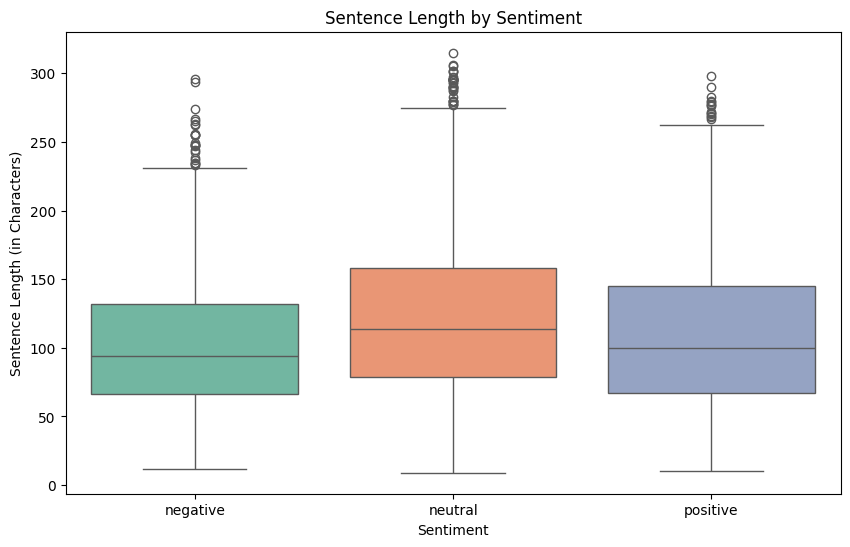

In [17]:
# Create a figure for visualizing sentence length variation across sentiment classes
plt.figure(figsize=(10, 6))
# Generate a boxplot comparing sentence lengths for each sentiment category
sns.boxplot(data=Findata_Data, x='sentiment', y='fin_sentence_length', hue='sentiment', palette='Set2', legend=False)
# Set the title of the plot
plt.title("Sentence Length by Sentiment")
# Label the x-axis and y-axis for sentiment and text length
plt.xlabel("Sentiment")
plt.ylabel("Sentence Length (in Characters)")
# Display the boxplot
plt.show()

In [18]:
# Download required NLTK resources for text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
# Initialize lemmatizer and define stopwords for financial text
fin_text_lemmatizer = WordNetLemmatizer()
fin_stopwords_set = set(stopwords.words('english'))
# Function to clean and preprocess a financial sentence
def preprocess_fin_sentence(fin_raw_text):
    """
    Preprocess a financial sentence by lowercasing, removing punctuation and stopwords, and lemmatizing words.

    Parameters:
    fin_raw_text (str): Raw sentence from financial news or reports.

    Returns:
    str: Cleaned and lemmatized sentence ready for modeling.
    """
    fin_lower = fin_raw_text.lower()
    fin_nopunct = re.sub(r'[^a-z\s]', '', fin_lower)
    fin_tokens = fin_nopunct.split()
    fin_clean_tokens = [fin_text_lemmatizer.lemmatize(word) for word in fin_tokens if word not in fin_stopwords_set]
    return ' '.join(fin_clean_tokens)
# Apply preprocessing to the 'sentence' column
Findata_Data['fin_sentence_cleaned'] = Findata_Data['sentence'].apply(preprocess_fin_sentence)
# Show a preview of original and cleaned financial sentences
Findata_Data[['sentence', 'fin_sentence_cleaned']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,sentence,fin_sentence_cleaned
0,The GeoSolutions technology will leverage Bene...,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",esi low bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",last quarter componenta net sale doubled eurm ...
3,According to the Finnish-Russian Chamber of Co...,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining percent sta...


In [19]:
# Display the first 5 rows of the balanced financial sentiment dataset
Balanced_FinSent_Data.head()

,sentence,sentiment,sentiment_encoded
0,The company said that its comparable operating...,negative,0
1,$TSLA stock gaining steam... Plus other notabl...,positive,2
2,BHP Billiton drags FTSE lower after slashing d...,negative,0
3,"Ahlstrom , headquartered in Helsinki , Finland...",neutral,1
4,HELSINKI ( Thomson Financial ) - Kone said it ...,positive,2


In [20]:
# Split the balanced financial dataset into training and testing sets (80/20 split)
fin_text_train, fin_text_test, fin_label_train, fin_label_test = train_test_split(
    Balanced_FinSent_Data['sentence'],
    Balanced_FinSent_Data['sentiment_encoded'],
    test_size=0.2,
    random_state=123456,
    stratify=Balanced_FinSent_Data['sentiment_encoded']
)
# Convert target labels to categorical type for compatibility with modeling
fin_label_train = fin_label_train.astype('category')
fin_label_test = fin_label_test.astype('category')

In [21]:
# Load the pre-trained BERT tokenizer (uncased lowercase version)
fin_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tokenize and encode the financial training and test sentences
fin_encoded_train = fin_tokenizer(fin_text_train.tolist(), truncation=True, padding=True, return_tensors='pt')
fin_encoded_test = fin_tokenizer(fin_text_test.tolist(), truncation=True, padding=True, return_tensors='pt')
# Convert sentiment labels to PyTorch tensors
fin_labels_train_tensor = torch.tensor(fin_label_train.cat.codes.values)
fin_labels_test_tensor = torch.tensor(fin_label_test.cat.codes.values)
# Create TensorDataset objects for training and testing
fin_train_dataset = TensorDataset(fin_encoded_train['input_ids'], fin_encoded_train['attention_mask'], fin_labels_train_tensor)
fin_test_dataset = TensorDataset(fin_encoded_test['input_ids'], fin_encoded_test['attention_mask'], fin_labels_test_tensor)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Load the pre-trained BERT model for multi-class sentiment classification
fin_model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(Sentiment_label_names)
).to(device)

# Set up the AdamW optimizer for BERT
fin_optimizer = AdamW(fin_model_bert.parameters(), lr=1e-5)

# Define the loss function for categorical sentiment prediction
fin_loss_function = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Create DataLoaders for training and testing batches
fin_sent_train_loader = DataLoader(fin_train_dataset, batch_size=8, shuffle=True)
fin_sent_test_loader = DataLoader(fin_test_dataset, batch_size=8)
# Lists to store accuracy and loss across epochs
fin_sent_train_acc_list = []
fin_sent_test_acc_list = []
fin_sent_epoch_loss_list = []
# Loop over training epochs
for epoch in range(5):  # Adjust number of epochs if needed
    fin_model_bert.train()
    epoch_total_loss = 0
    epoch_correct_preds = 0
    epoch_total_samples = 0
    # Training phase
    for fin_batch in tqdm(fin_sent_train_loader, desc=f"Epoch {epoch+1} - Training"):
        fin_input_ids, fin_attn_masks, fin_sent_labels = [b.to(device) for b in fin_batch]
        fin_sent_labels = fin_sent_labels.long()
        # Forward pass
        fin_optimizer.zero_grad()
        fin_bert_outputs = fin_model_bert(input_ids=fin_input_ids, attention_mask=fin_attn_masks)
        fin_batch_loss = fin_loss_function(fin_bert_outputs.logits, fin_sent_labels)
        # Backward pass and optimizer step
        fin_batch_loss.backward()
        fin_optimizer.step()
        # Accumulate metrics
        epoch_total_loss += fin_batch_loss.item()
        fin_batch_preds = torch.argmax(fin_bert_outputs.logits, dim=1)
        epoch_correct_preds += (fin_batch_preds == fin_sent_labels).sum().item()
        epoch_total_samples += fin_sent_labels.size(0)
    # Calculate training metrics
    train_epoch_acc = epoch_correct_preds / epoch_total_samples
    fin_sent_train_acc_list.append(train_epoch_acc)
    fin_sent_epoch_loss_list.append(epoch_total_loss / len(fin_sent_train_loader))
    # Evaluation phase
    fin_model_bert.eval()
    test_correct_preds = 0
    test_total_samples = 0
    with torch.no_grad():
        for fin_batch in fin_sent_test_loader:
            fin_input_ids, fin_attn_masks, fin_sent_labels = [b.to(device) for b in fin_batch]
            fin_sent_labels = fin_sent_labels.long()
            fin_bert_outputs = fin_model_bert(input_ids=fin_input_ids, attention_mask=fin_attn_masks)
            fin_batch_preds = torch.argmax(fin_bert_outputs.logits, dim=1)
            test_correct_preds += (fin_batch_preds == fin_sent_labels).sum().item()
            test_total_samples += fin_sent_labels.size(0)
    # Calculate test accuracy
    test_epoch_acc = test_correct_preds / test_total_samples
    fin_sent_test_acc_list.append(test_epoch_acc)
    # Print metrics for the current epoch
    print(f"Epoch {epoch+1}:")
    print(f"  Training Accuracy : {train_epoch_acc:.4f}")
    print(f"  Testing Accuracy  : {test_epoch_acc:.4f}")
    print(f"  Average Loss      : {epoch_total_loss / len(fin_sent_train_loader):.4f}")

Epoch 1 - Training: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


Epoch 1:
  Training Accuracy : 0.7646
  Testing Accuracy  : 0.8672
  Average Loss      : 0.5848


Epoch 2 - Training: 100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


Epoch 2:
  Training Accuracy : 0.8880
  Testing Accuracy  : 0.8837
  Average Loss      : 0.2976


Epoch 3 - Training: 100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


Epoch 3:
  Training Accuracy : 0.9165
  Testing Accuracy  : 0.8901
  Average Loss      : 0.2187


Epoch 4 - Training: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


Epoch 4:
  Training Accuracy : 0.9268
  Testing Accuracy  : 0.8960
  Average Loss      : 0.1906


Epoch 5 - Training: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


Epoch 5:
  Training Accuracy : 0.9329
  Testing Accuracy  : 0.8901
  Average Loss      : 0.1724


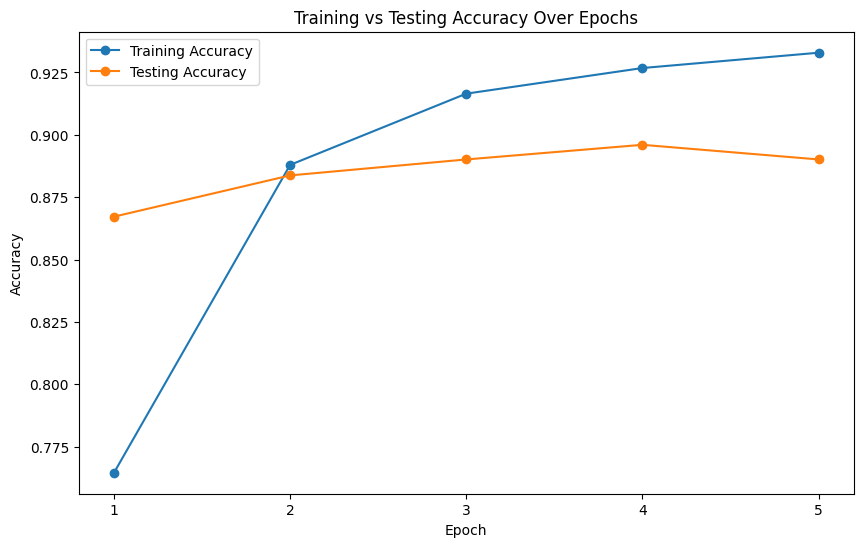

In [24]:
# Create a list of epoch numbers for plotting
fin_num_epochs = list(range(1, len(fin_sent_train_acc_list) + 1))
# Create the figure for the accuracy plot
plt.figure(figsize=(10, 6))
# Plot training accuracy across epochs
plt.plot(fin_num_epochs, fin_sent_train_acc_list, marker='o', label='Training Accuracy')
# Plot testing accuracy across epochs
plt.plot(fin_num_epochs, fin_sent_test_acc_list, marker='o', label='Testing Accuracy')
# Add title and axis labels
plt.title("Training vs Testing Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# Add x-tick marks for each epoch
plt.xticks(fin_num_epochs)
# Display legend and the plot
plt.legend()
plt.show()

In [26]:
# Set the BERT model to evaluation mode
fin_model_bert.eval()
# Create DataLoader for test data
fin_sent_test_loader = DataLoader(fin_test_dataset, batch_size=8)
# Initialize lists to collect predictions and true labels
fin_sent_preds = []
fin_sent_true = []
# Perform model inference without gradient calculation
with torch.no_grad():
    for batch in fin_sent_test_loader:
        fin_test_input_ids, fin_test_attn_masks, fin_test_labels = [b.to(device) for b in batch]
        fin_test_outputs = fin_model_bert(input_ids=fin_test_input_ids, attention_mask=fin_test_attn_masks)
        fin_predicted_labels = torch.argmax(fin_test_outputs.logits, dim=1)
        fin_sent_preds.extend(fin_predicted_labels.cpu().numpy())
        fin_sent_true.extend(fin_test_labels.cpu().numpy())
# Compute and display overall test accuracy
fin_test_overall_acc = accuracy_score(fin_sent_true, fin_sent_preds)
print(f"Test Accuracy on Financial Sentiment Data: {fin_test_overall_acc:.2f}")
# Print detailed classification metrics
print("\n Classification Report on Financial Sentiment Data:\n")
print(classification_report(fin_sent_true, fin_sent_preds, target_names=Sentiment_label_names))


Test Accuracy on Financial Sentiment Data: 0.89

 Classification Report on Financial Sentiment Data:

              precision    recall  f1-score   support

    negative       0.83      0.98      0.90       625
     neutral       0.95      0.74      0.83       625
    positive       0.92      0.96      0.94       625

    accuracy                           0.89      1875
   macro avg       0.90      0.89      0.89      1875
weighted avg       0.90      0.89      0.89      1875



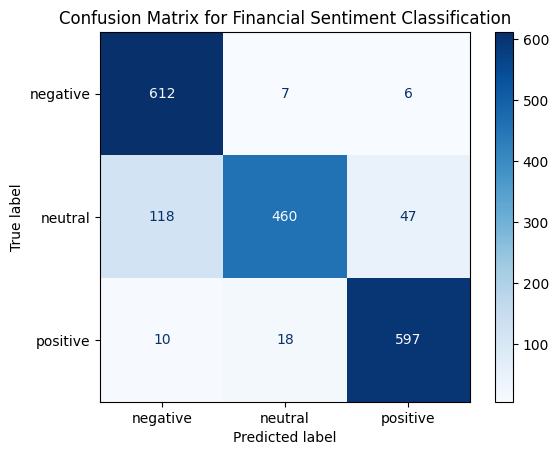

In [27]:
# Compute the confusion matrix using true and predicted sentiment labels
fin_conf_matrix = confusion_matrix(fin_sent_true, fin_sent_preds)
# Create a display object for the confusion matrix with class labels
fin_conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=fin_conf_matrix, display_labels=Sentiment_label_names)
# Plot the confusion matrix using a blue color map
fin_conf_matrix_display.plot(cmap='Blues')
# Add a title to the plot
plt.title("Confusion Matrix for Financial Sentiment Classification")
# Show the plot
plt.show()

In [30]:
# Randomly select 5 test samples to compare predictions
fin_test_sample_indices = np.random.choice(len(fin_text_test), 5, replace=False)
# Loop through selected samples
for idx in fin_test_sample_indices:
    # Get the original test sentence
    fin_sample_text = fin_text_test.iloc[idx]
    # Get the actual sentiment label
    fin_actual_label = Sentiment_label_names[fin_label_test.iloc[idx]]
    # Tokenize and send the input to the model
    fin_input_tokens = fin_tokenizer(fin_sample_text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        fin_model_output = fin_model_bert(**fin_input_tokens)
    # Get predicted sentiment label
    fin_predicted_label = Sentiment_label_names[torch.argmax(fin_model_output.logits, dim=1).item()]
    # Print the sentence with actual and predicted labels
    print("\n Sample Financial Sentence:")
    print(fin_sample_text)
    print("Original Sentiment   :", fin_actual_label)
    print("Predicted Sentiment :", fin_predicted_label)


 Sample Financial Sentence:
The Costanza light , with an aluminum base and washable shade , comes in white , pistachio , orange , blue and red .
Original Sentiment   : neutral
Predicted Sentiment : neutral

 Sample Financial Sentence:
The Boeing Company (NYSE:BA) Bearish Trader bets $550K that Stock Will Sell Off 9.79% by July Expiry $BA http://stks.co/tCSE
Original Sentiment   : negative
Predicted Sentiment : negative

 Sample Financial Sentence:
A filter is used to pre-process packets to determine if they need to be further processed by the processor of the network device .
Original Sentiment   : neutral
Predicted Sentiment : neutral

 Sample Financial Sentence:
WPP, World's Largest Ad Agency, Reports Strong 2015 Growth
Original Sentiment   : positive
Predicted Sentiment : positive

 Sample Financial Sentence:
Aspen to Buy Anaesthetics From AstraZeneca for $520 Million
Original Sentiment   : positive
Predicted Sentiment : positive
